# Relational Data Modeling

In this tutorial we will be showing how to model a real world multi-table dataset using SDV.

## About the datset

We have a store series, each of those have a size and a category and additional information in a given date: average temperature in the region, cost of fuel in the region, promotional data, the customer price index, the unemployment rate and whether the date is a special holiday.

From those stores we obtained a training of historical data 
between 2010-02-05 and 2012-11-01. This historical data includes the sales of each department on a specific date.
In this notebook, we will show you step-by-step how to download the "Walmart" dataset, explain the structure and sample the data.

In this demonstration we will show how SDV can be used to generate synthetic data. And lately, this data can be used to train machine learning models.

*The dataset used in this example can be found in [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data), but we will show how to download it from SDV.*

### Data model summary

<p style="text-align: center"><b>stores</b><p>

| Field | Type        | Subtype | Additional Properties |
|-------|-------------|---------|-----------------------|
| Store | id          | integer | Primary key           |
| Size  | numerical   | integer |                       |
| Type  | categorical |         |                       |

Contains information about the 45 stores, indicating the type and size of store.

<p style="text-align: center"><b>features</b><p>

| Fields       | Type      | Subtype | Additional Properties       |
|--------------|-----------|---------|-----------------------------|
| Store        | id        | integer | foreign key (stores.Store)  |
| Date         | datetime  |         | format: "%Y-%m-%d"          |
| IsHoliday    | boolean   |         |                             |
| Fuel_Price   | numerical | float   |                             |
| Unemployment | numerical | float   |                             |
| Temperature  | numerical | float   |                             |
| CPI          | numerical | float   |                             |
| MarkDown1    | numerical | float   |                             |
| MarkDown2    | numerical | float   |                             |
| MarkDown3    | numerical | float   |                             |
| MarkDown4    | numerical | float   |                             |
| MarkDown5    | numerical | float   |                             |

Contains historical training data, which covers to 2010-02-05 to 2012-11-01.

<p style="text-align: center"><b>depts</b><p>

| Fields       | Type      | Subtype | Additional Properties        |
|--------------|-----------|---------|------------------------------|
| Store        | id        | integer | foreign key (stores.Stores)  |
| Date         | datetime  |         | format: "%Y-%m-%d"           |
| Weekly_Sales | numerical | float   |                              |
| Dept         | numerical | integer |                              |
| IsHoliday    | boolean   |         |                              |

Contains additional data related to the store, department, and regional activity for the given dates.

### 1. Load data

Let's start downloading the data set. In this case, we will download the data set *walmart*. We will use the SDV function `load_demo`, we can specify the name of the dataset we want to use and if we want its Metadata object or not. To know more about the demo data [see the documentation](https://sdv-dev.github.io/SDV/api/sdv.demo.html).

In [1]:
# Setup logging and warnings
import logging;
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(level=logging.WARNING)
logging.getLogger('sdv').setLevel(level=logging.INFO)

import warnings
warnings.simplefilter("ignore")

In [2]:
from sdv import load_demo

metadata, tables = load_demo(dataset_name='walmart', metadata=True)

2020-08-05 20:21:53,505 - INFO - sdv.metadata - Loading table stores
2020-08-05 20:21:53,513 - INFO - sdv.metadata - Loading table features
2020-08-05 20:21:53,526 - INFO - sdv.metadata - Loading table depts


Our dataset is downloaded from an [Amazon S3 bucket](http://sdv-datasets.s3.amazonaws.com/index.html) that contains all available data sets of the `load_demo` method.

We can now visualize the metadata structure

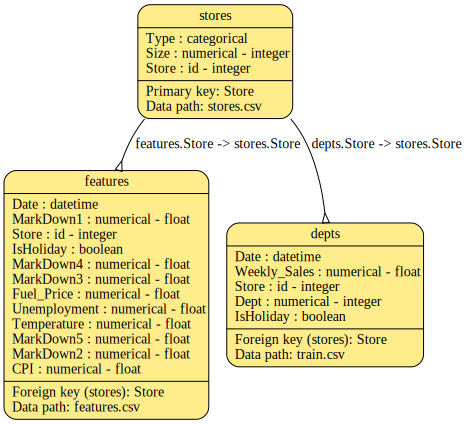

In [3]:
metadata.visualize()

And also validate that the metadata is correctly defined for our data

In [4]:
metadata.validate(tables)

In [5]:
from sdv.utils import display_tables

display_tables(tables)

stores,features,depts
Store,Type,Size
1,A,151315
2,A,202307
3,B,37392
4,A,205863
5,B,34875
6,A,202505
7,B,70713
8,A,155078
9,B,125833


### 2. Create an instance of SDV and train the instance

Once we download it, we have to create an SDV instance. With that instance, we have to analyze the loaded tables to generate a statistical model from the data. In this case, the process of adjusting the model is quickly because the dataset is small. However, with larger datasets it can be a slow process.

In [6]:
from sdv import SDV

sdv = SDV()
sdv.fit(metadata, tables=tables)

2020-08-05 20:21:55,259 - INFO - sdv.modeler - Modeling stores
2020-08-05 20:21:55,260 - INFO - sdv.metadata - Loading transformer CategoricalTransformer for field Type
2020-08-05 20:21:55,260 - INFO - sdv.metadata - Loading transformer NumericalTransformer for field Size
2020-08-05 20:21:55,269 - INFO - sdv.modeler - Modeling depts
2020-08-05 20:21:55,269 - INFO - sdv.metadata - Loading transformer DatetimeTransformer for field Date
2020-08-05 20:21:55,270 - INFO - sdv.metadata - Loading transformer NumericalTransformer for field Weekly_Sales
2020-08-05 20:21:55,270 - INFO - sdv.metadata - Loading transformer NumericalTransformer for field Dept
2020-08-05 20:21:55,270 - INFO - sdv.metadata - Loading transformer BooleanTransformer for field IsHoliday
2020-08-05 20:21:56,148 - INFO - sdv.modeler - Modeling features
2020-08-05 20:21:56,149 - INFO - sdv.metadata - Loading transformer DatetimeTransformer for field Date
2020-08-05 20:21:56,149 - INFO - sdv.metadata - Loading transformer Num

Note: We may not want to train the model every time we want to generate new synthetic data. We can [save](https://sdv-dev.github.io/SDV/api/sdv.sdv.html#sdv.sdv.SDV.save) the SDV instance to [load](https://sdv-dev.github.io/SDV/api/sdv.sdv.html#sdv.sdv.SDV.save) it later.

### 3. Generate synthetic data

Once the instance is trained, we are ready to generate the synthetic data.

The easiest way to generate synthetic data for the entire dataset is to call the `sample_all` method. By default, this method generates only 5 rows, but we can specify the row number that will be generated with the `num_rows` argument. To learn more about the available arguments, see [sample_all](https://sdv-dev.github.io/SDV/api/sdv.sampler.html#sdv.sampler.Sampler.sample_all).

In [7]:
sdv.modeler.table_sizes

{'stores': 45, 'depts': 421570, 'features': 8190}

In [8]:
samples = sdv.sample_all()

This returns a dictionary with the same format as the input `tables`, with
a `pandas.DataFrame` for each table.

In [9]:
samples.keys()

dict_keys(['stores', 'depts', 'features'])

In [10]:
display_tables(samples)

stores,depts,features
Type,Size,Store
A,238835,0
C,207057,1
A,185450,2
A,121853,3
A,232242,4
A,77979,5
A,176550,6
C,97136,7
B,76354,8


We may not want to generate data for all tables in the dataset, rather for just one table. This is possible with SDV using the `sample` method. To use it we only need to specify the name of the table we want to synthesize and the row numbers to generate. In this case, the "walmart" data set has 3 tables: stores, features and depts.

In the following example, we will generate 1000 rows of the "features" table.

In [11]:
sdv.sample('features', 1000, sample_children=False)

,Date,MarkDown1,Store,IsHoliday,MarkDown4,MarkDown3,Fuel_Price,Unemployment,Temperature,MarkDown5,MarkDown2,CPI
0,2011-05-16 22:12:16.719949312,NaN,45,False,NaN,-3522.610360,3.557379,10.119276,84.948873,NaN,NaN,130.097566
1,2012-05-07 18:21:57.668985856,13882.743393,49,False,10409.402379,392.508334,3.696959,7.697493,49.363466,4296.996403,-432.020252,122.412264
2,2010-09-09 01:38:54.464363264,NaN,46,False,NaN,NaN,2.981501,8.281216,99.879443,NaN,NaN,134.195498
3,2012-01-25 14:53:44.246531840,9927.716783,48,True,5438.785435,NaN,3.467548,9.272527,69.947886,NaN,3538.205782,121.043138
4,2011-07-03 02:42:31.676273408,14814.954099,49,False,8365.552143,6867.661993,2.741602,7.094083,87.784597,8220.514161,425.358506,236.021879
5,2012-02-27 06:10:45.754697472,8816.901591,45,False,NaN,2263.174004,3.989228,8.134336,82.983094,4682.423318,NaN,177.070555
6,2009-06-25 00:57:40.227447552,NaN,45,False,NaN,NaN,2.406865,8.877070,35.395686,NaN,NaN,191.663563
7,2012-11-08 12:02:01.170885888,3067.194088,46,False,2143.278025,761.688935,3.686846,6.783572,27.675874,1340.924945,3653.037306,128.662878
8,2011-08-01 05:01:06.322296576,9369.668949,45,False,4459.373644,6272.463483,3.273961,10.398373,48.396609,8529.139835,10030.259069,157.443283
9,2010-12-21 01:50:51.813451264,NaN,47,False,NaN,NaN,2.983382,9.394405,59.193581,NaN,NaN,160.979347


SDV has tools to evaluate the synthetic data generated and compare them with the original data. To see more about the evaluation tools, [see the documentation](https://sdv-dev.github.io/SDV/api/sdv.evaluation.html#sdv.evaluation.evaluate).